In [1]:
# add modules folder to Python's search path
import os, sys
from pathlib import Path
script_dir = Path(os.path.dirname(os.path.abspath('')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
print(module_dir)

# import the rest of the modules
%matplotlib nbagg
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import utility as ut
from scipy.special import erf

C:\Users\pinak\Documents\GitHub\fp-solvers


**Define $p_0,\mu, p_\infty$**

In [2]:
DTYPE = 'float32'
sigma_0 = 0.5
c = 2. * np.pi * sigma_0**2
sigma = np.sqrt(2., dtype= DTYPE)
D = sigma**2 / 2.
Z = 0.5 * np.sqrt(np.pi**3 * D) * (1. + erf(1/np.sqrt(D)))
logZ = np.log(Z)
save_folder = '../circle-fp/data'
dt = 0.01
n_steps = 1
root2 = np.sqrt(2., dtype= DTYPE)

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def left(x, y):
    return np.exp(-((x+.5)**2 + (y+.5)**2)/(2.*sigma_0**2)) / c

def right(x, y):
    return np.exp(-((x-.5)**2 + (y-.5)**2)/(2.*sigma_0**2)) / c

def middle(x, y):
    return 0.5 * left(x, y) + 0.5 * right(x, y)

def get_p0(dim):
    def p0(X):
        args = np.split(X, dim, axis=-1)
        a = [args[i:i+2] for i in range(0, dim, 2)]
        val = 1.0
        for x, y in a:
            val *= middle(x, y)
        return val
    return p0

def get_mu(dim):
    def mu(X):
        args = np.split(X, dim, axis=-1)
        a = [args[i:i+2] for i in range(0, dim, 2)]
        arr = []
        for x, y in a:
            z = -4. * (x*x + y*y - 1.)
            arr += [x*z, y*z]
        return np.concatenate(arr, axis=-1)
    return mu

def get_p_inf(dim):
    def p_inf(X):
        args = np.split(X, dim, axis=-1)
        a = [args[i:i+2] for i in range(0, dim, 2)]
        val = 0.0
        for x, y in a:
            val -= ((x*x + y*y - 1.)**2) / D + logZ
        return np.exp(val)
    return p_inf

def get_h0(dim):
    p0, p_inf = get_p0(dim), get_p_inf(dim)
    def h0(X):
      return p0(X) / p_inf(X)
    return h0

def get_endpts(dim, n_repeats):
    X = np.ones((n_repeats, dim), dtype=DTYPE) / root2
    dW = np.random.normal(scale=np.sqrt(dt), size=(n_steps, n_repeats, dim)).astype(DTYPE)
    mu = get_mu(dim)
    for step in range(n_steps):
        X += mu(X) * dt + sigma * dW[step]
    return X

@ut.timer
def fk(dim, n_repeats, m=10):
    p_inf, h0 = get_p_inf(dim), get_h0(dim)
    x0 = np.ones((1, dim), dtype=DTYPE) / root2
    val = 0.
    for i in range(m):
      X = get_endpts(dim, n_repeats)
      val += p_inf(x0)[0, 0] * (h0(X).sum()) / n_repeats
    return val/m

def solve(dim):
    print("Solving for d = {}".format(dim))
    n_particles = [1, 100, 10000, 1000000, 2000000]
    sol = np.zeros(len(n_particles))
    j = int(dim/2) - 1
    for i, n in enumerate(n_particles):
      sol[i] = fk(dim, n)
    pd.DataFrame({'N': n_particles, 'sol': sol}).to_csv('{}/sol{}D.csv'.format(save_folder, dim), index=None)
    return sol

def get_sol(dim):
    df = pd.read_csv('{}/sol{}D.csv'.format(save_folder, dim))
    return df['N'].to_numpy(), df['sol'].to_numpy()

def get_truth(dim):
    t = get_sol(2)[-1][-1]
    return t**(dim/2)

def plot(d):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    for dim in range(d, 12, 2):
      n, s = get_sol(dim)
      t = get_truth(dim)
      s = s**(2/dim)
      e = np.abs(s-s[-1])
      ax.plot(np.log10(n[:-1]), np.log10(e[:-1]), label='d={}'.format(dim))
      ax.legend()
    plt.show()

**Solve for d = 2, 4, 6, 8, 10**

Solving for d = 2
Time taken by fk is 0.0010023117065429688 seconds
Time taken by fk is 0.002004861831665039 seconds
Time taken by fk is 0.006531715393066406 seconds
Time taken by fk is 0.808814525604248 seconds
Time taken by fk is 1.710120439529419 seconds
Solving for d = 4
Time taken by fk is 0.0 seconds
Time taken by fk is 0.004001617431640625 seconds
Time taken by fk is 0.012520790100097656 seconds
Time taken by fk is 1.9322271347045898 seconds
Time taken by fk is 3.600896120071411 seconds
Solving for d = 6
Time taken by fk is 0.003997802734375 seconds
Time taken by fk is 0.0 seconds
Time taken by fk is 0.020630836486816406 seconds
Time taken by fk is 2.706620216369629 seconds
Time taken by fk is 5.481534719467163 seconds
Solving for d = 8
Time taken by fk is 0.004001140594482422 seconds
Time taken by fk is 0.00400090217590332 seconds
Time taken by fk is 0.020994901657104492 seconds
Time taken by fk is 3.8131847381591797 seconds
Time taken by fk is 7.437899827957153 seconds
Solving

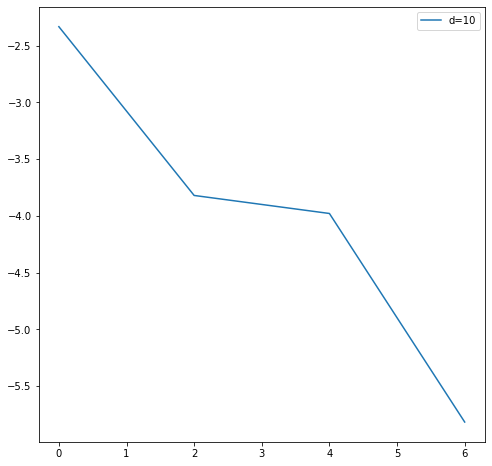

Time taken by this cell = 42.3019802570343


In [4]:
start = time.time()
dim = 10
for d in [2, 4, 6, 8, 10]:
    solve(d)
plot(dim)
end = time.time()
print('Time taken by this cell = {}'.format(end-start))

In [ ]:
plot(2)